In [ ]:
!pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
!python3 -c "import torch; print(torch.__version__)"

2.4.1+cu121


In [ ]:
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cu121.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 111.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 986.2/986.2 kB 20.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in

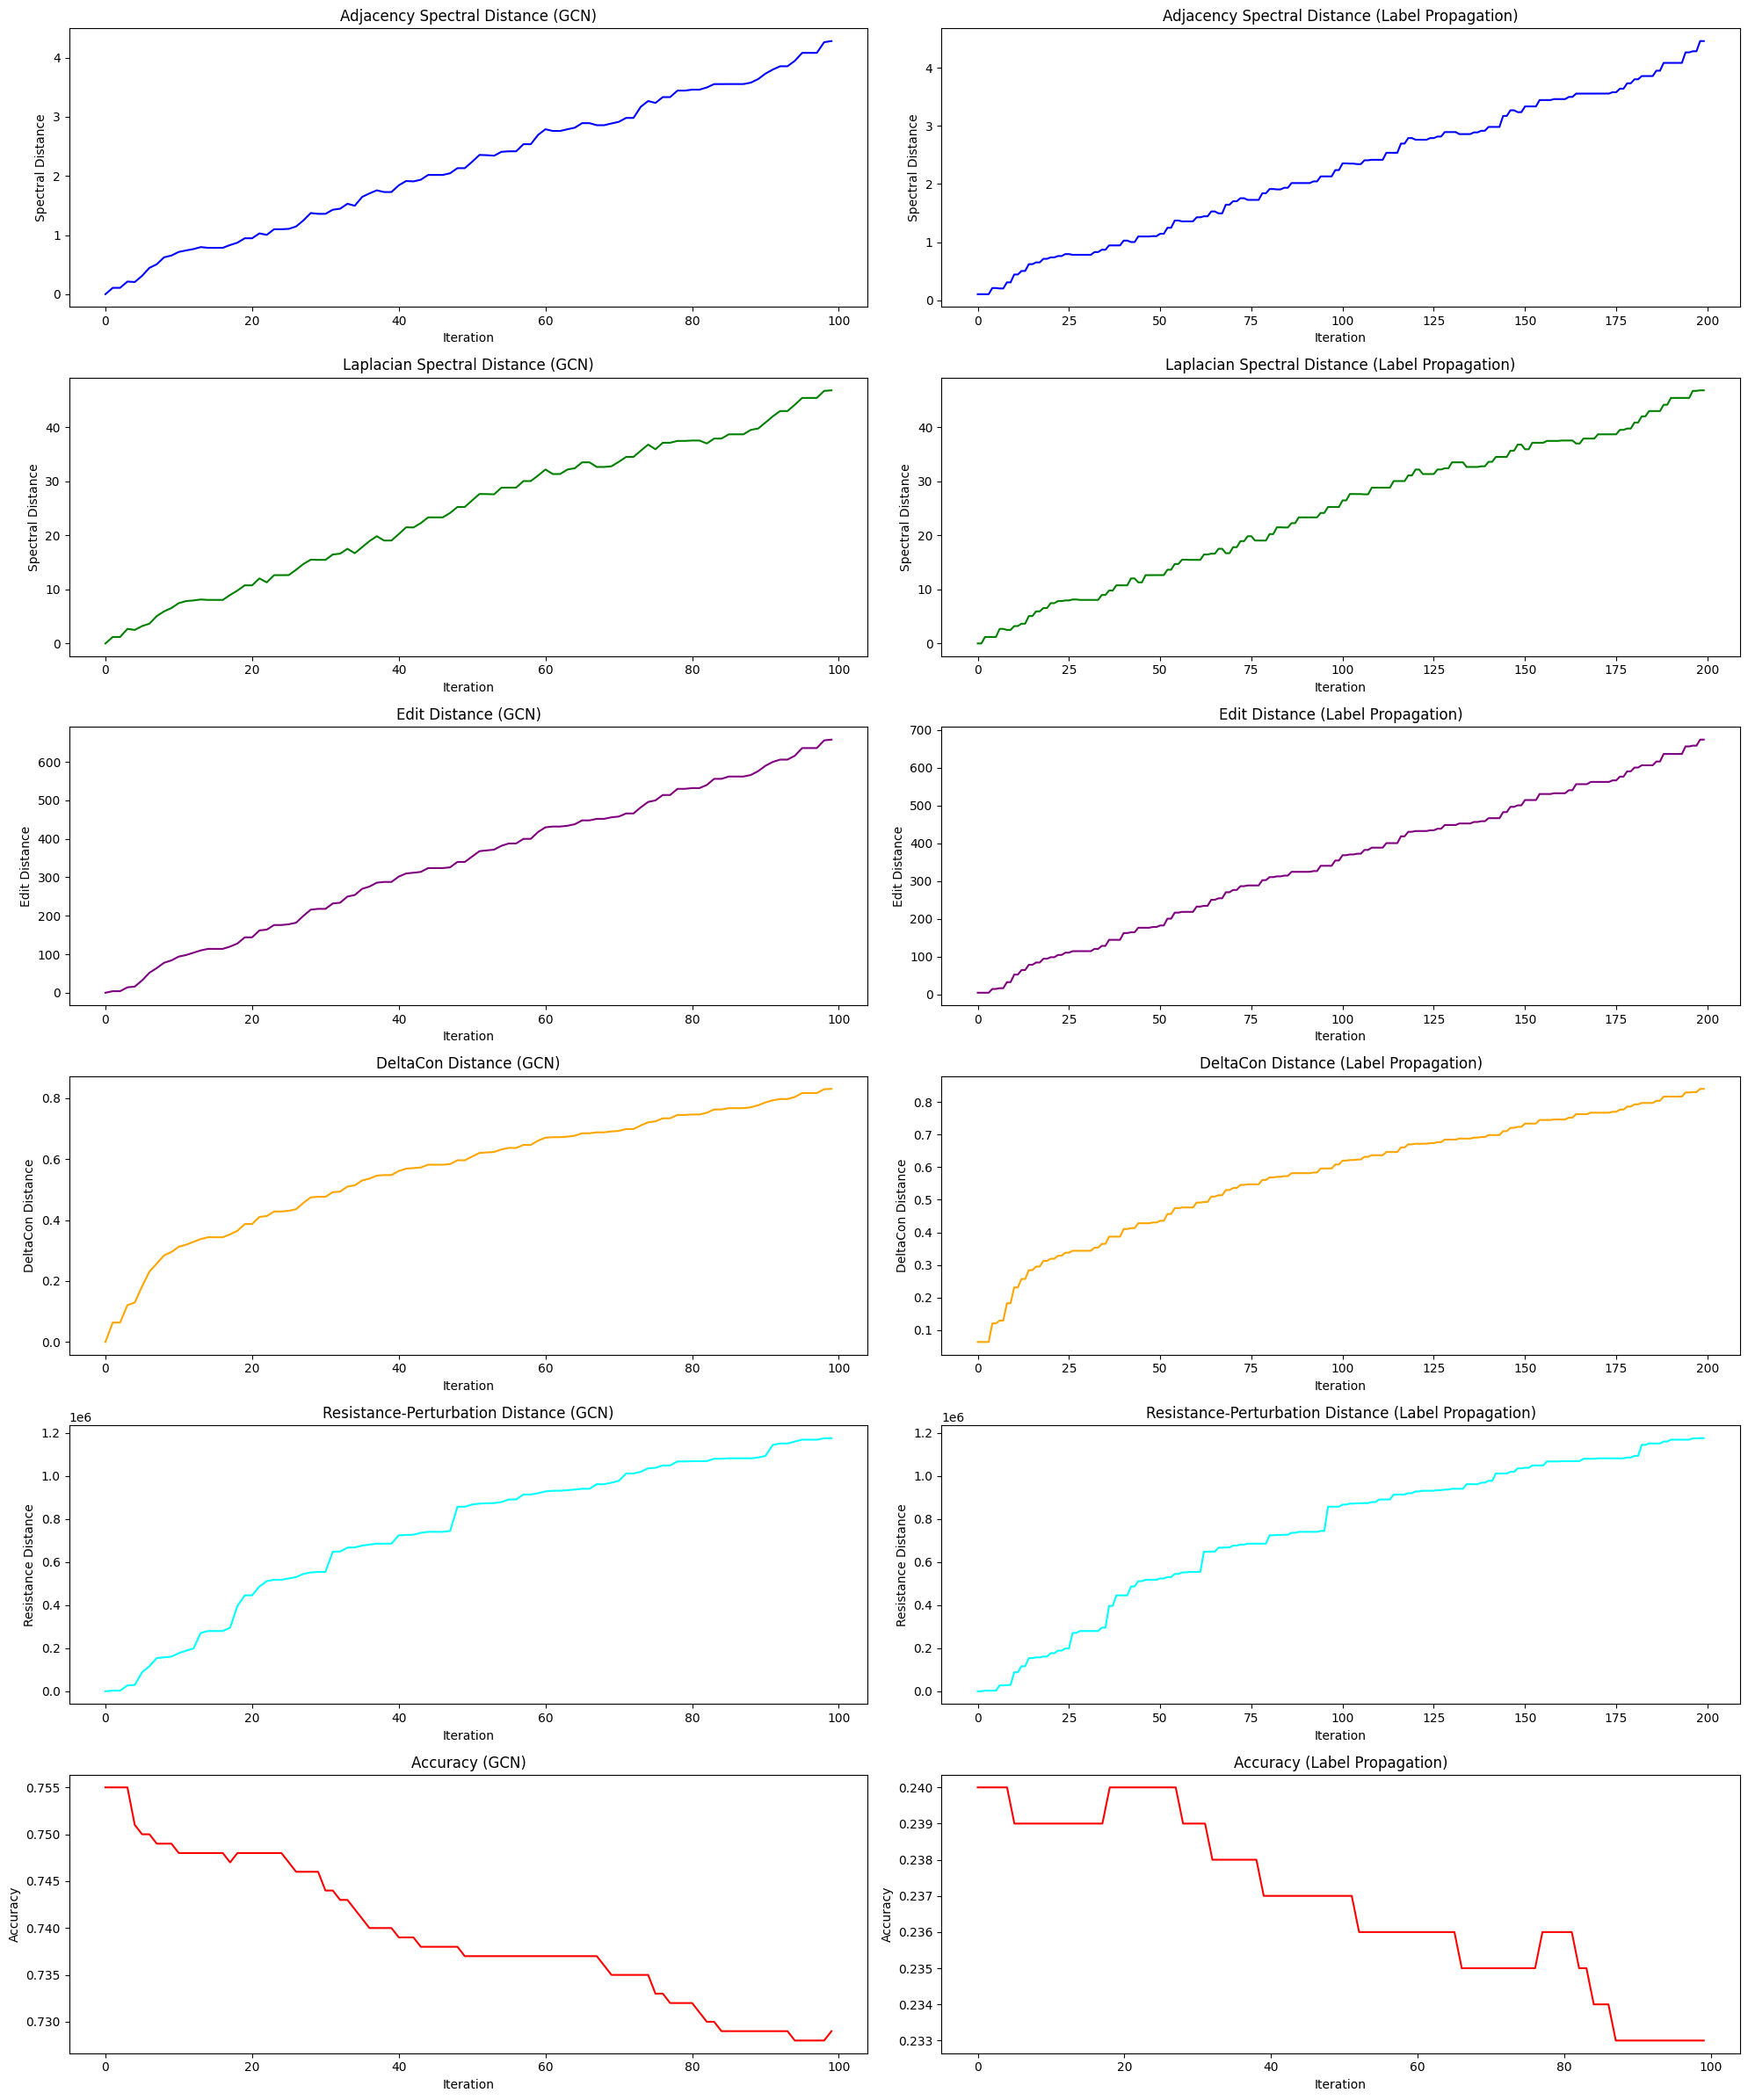

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import networkx as nx
import random
from sklearn.semi_supervised import LabelPropagation

# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, with_relu=True, dropout=0.5):
        super(GCN, self).__init__()
        self.with_relu = with_relu
        self.dropout = dropout
        self.fc1 = torch.nn.Linear(in_channels, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, adj):
        x = torch.matmul(adj, x)
        x = self.fc1(x)
        if self.with_relu:
            x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.matmul(adj, x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Convert edge_index to dense adjacency matrix
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dense_adj = to_dense_adj(data.edge_index)[0].to(device)

# Normalize the dense adjacency matrix
degree = torch.sum(dense_adj, dim=1)
degree_inv_sqrt = degree.pow(-0.5)
degree_inv_sqrt[degree_inv_sqrt == float('inf')] = 0
dense_adj = degree_inv_sqrt.view(-1, 1) * dense_adj * degree_inv_sqrt.view(1, -1)

# Train the GCN model
model = GCN(dataset.num_node_features, 16, dataset.num_classes, with_relu=True, dropout=0.5).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, dense_adj)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])  # Train on train_mask
    loss.backward()
    optimizer.step()

# Function to compute the graph Laplacian
def compute_laplacian(adj):
    degree_matrix = torch.diag(torch.sum(adj, dim=1))
    laplacian = degree_matrix - adj
    return laplacian

# Function to compute the spectral distance between two matrices (adjacency or Laplacian)
def spectral_distance(matrix1, matrix2):
    eigenvalues1 = torch.linalg.eigvalsh(matrix1)
    eigenvalues2 = torch.linalg.eigvalsh(matrix2)
    distance = torch.sqrt(torch.sum((eigenvalues1 - eigenvalues2) ** 2)).item()
    return distance

# Function to compute the edit distance between two matrices
def edit_distance(matrix1, matrix2):
    distance = torch.sum(torch.abs(matrix1 - matrix2)).item()
    return distance

# Function to compute the DeltaCon belief propagation matrix S
def compute_deltacon_matrix(adj, epsilon=1e-3):
    degree_matrix = torch.diag(torch.sum(adj, dim=1))
    identity_matrix = torch.eye(adj.size(0)).to(adj.device)
    S = torch.linalg.inv(identity_matrix + epsilon**2 * degree_matrix - epsilon * adj)
    return S

# Function to compute the DeltaCon distance
def deltacon_distance(S1, S2):
    distance = torch.sqrt(torch.sum((torch.sqrt(S1) - torch.sqrt(S2))**2)).item()
    return distance

# Function to compute the effective resistance matrix R
def compute_resistance_matrix(laplacian):
    laplacian_pseudo_inverse = torch.linalg.pinv(laplacian)
    identity_matrix = torch.eye(laplacian.size(0)).to(laplacian.device)
    resistance_matrix = torch.diag(laplacian_pseudo_inverse)[:, None] + torch.diag(laplacian_pseudo_inverse)[None, :] - 2 * laplacian_pseudo_inverse
    return resistance_matrix

# Function to compute the resistance-perturbation distance
def resistance_perturbation_distance(R1, R2):
    distance = torch.sum(torch.abs(R1 - R2)).item()
    return distance

# Function to calculate betweenness centrality using NetworkX
def calculate_betweenness_centrality(edge_index, num_nodes):
    G = to_networkx(data, to_undirected=True)
    centrality = nx.betweenness_centrality(G)
    centrality_scores = torch.tensor([centrality[i] for i in range(num_nodes)], dtype=torch.float32)
    return centrality_scores

# Initialize lists to store the distances and accuracy changes for GCN and label propagation
results = {
    "betweenness": {
        "gcn": {
            "adj_spectral_distances": [],
            "laplacian_spectral_distances": [],
            "edit_distances": [],
            "deltacon_distances": [],
            "resistance_distances": [],
            "accuracy_changes": []
        },
        "label_propagation": {
            "adj_spectral_distances": [],
            "laplacian_spectral_distances": [],
            "edit_distances": [],
            "deltacon_distances": [],
            "resistance_distances": [],
            "accuracy_changes": []
        }
    }
}

# Assuming original_dense_adj is the adjacency matrix before attack
original_dense_adj = to_dense_adj(data.edge_index)[0].to(device)
original_laplacian = compute_laplacian(original_dense_adj)
original_deltacon_matrix = compute_deltacon_matrix(original_dense_adj)
original_resistance_matrix = compute_resistance_matrix(original_laplacian)

# Calculate betweenness centrality
betweenness_centrality_scores = calculate_betweenness_centrality(data.edge_index, data.num_nodes)

# Select top nodes based on betweenness centrality scores
_, top_betweenness_nodes = torch.topk(betweenness_centrality_scores, k=10)

# Attack loop for betweenness centrality with label propagation
modified_adj_betweenness = original_dense_adj.clone()
for i in range(100):
    target_node = target_node = random.choice(range(len(data.y)))
    target_label = data.y[target_node]

    # Forward pass and loss calculation using dense_adj
    dense_adj.requires_grad_(True)
    out = model(data.x, dense_adj)
    loss = F.nll_loss(out[target_node].unsqueeze(0), target_label.unsqueeze(0))

    # Backpropagation to get gradients
    adj_grad = torch.autograd.grad(loss, dense_adj, retain_graph=True)[0]

    # Symmetrize the gradients
    g_hat = (adj_grad + adj_grad.t()) / 2

    # Extract the most significant links
    topk = 20  # Number of links to consider for attack
    indices = g_hat.abs().flatten().topk(topk).indices
    rows = indices // g_hat.size(0)
    cols = indices % g_hat.size(0)
    modified_laplacian_betweenness = compute_laplacian(modified_adj_betweenness)
    results["betweenness"]["gcn"]["adj_spectral_distances"].append(
        spectral_distance(original_dense_adj, modified_adj_betweenness)
    )
    results["betweenness"]["gcn"]["laplacian_spectral_distances"].append(
        spectral_distance(original_laplacian, modified_laplacian_betweenness)
    )
    results["betweenness"]["gcn"]["edit_distances"].append(
        edit_distance(original_dense_adj, modified_adj_betweenness)
    )
    modified_deltacon_matrix_betweenness = compute_deltacon_matrix(modified_adj_betweenness)
    results["betweenness"]["gcn"]["deltacon_distances"].append(
        deltacon_distance(original_deltacon_matrix, modified_deltacon_matrix_betweenness)
    )
    modified_resistance_matrix_betweenness = compute_resistance_matrix(modified_laplacian_betweenness)
    results["betweenness"]["gcn"]["resistance_distances"].append(
        resistance_perturbation_distance(original_resistance_matrix, modified_resistance_matrix_betweenness)
    )

    # Apply the attack by modifying the adjacency matrix
    for row, col in zip(rows, cols):
        if row != col:  # Skip self-loops
            gradient = torch.sign(g_hat[row, col])
            if modified_adj_betweenness[row, col] == 1:
                modified_adj_betweenness[row, col] = modified_adj_betweenness[row, col] + gradient
                z = min(1, modified_adj_betweenness[row, col])
                modified_adj_betweenness[row, col] = z
                modified_adj_betweenness[col, row] = z
            else:
                modified_adj_betweenness[row, col] = modified_adj_betweenness[row, col] + gradient
                z = max(0, modified_adj_betweenness[row, col])
                modified_adj_betweenness[row, col] = z
                modified_adj_betweenness[col, row] = z

    # GCN - Compute distances and accuracy after the attack


    model.eval()
    with torch.no_grad():
        out = model(data.x, modified_adj_betweenness)
        pred = out.argmax(dim=1)
        acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()  # Evaluate on test_mask
    results["betweenness"]["gcn"]["accuracy_changes"].append(acc)

    # Label Propagation - Use built-in LabelPropagation from sklearn
    G = to_networkx(data, to_undirected=True)
    A = nx.to_numpy_array(G)
    labels = data.y.cpu().numpy()  # Ground truth labels
    results["betweenness"]["label_propagation"]["adj_spectral_distances"].append(
        spectral_distance(original_dense_adj, modified_adj_betweenness)
    )
    results["betweenness"]["label_propagation"]["laplacian_spectral_distances"].append(
        spectral_distance(original_laplacian, modified_laplacian_betweenness)
    )
    results["betweenness"]["label_propagation"]["edit_distances"].append(
        edit_distance(original_dense_adj, modified_adj_betweenness)
    )
    modified_deltacon_matrix_betweenness = compute_deltacon_matrix(modified_adj_betweenness)
    results["betweenness"]["label_propagation"]["deltacon_distances"].append(
        deltacon_distance(original_deltacon_matrix, modified_deltacon_matrix_betweenness)
    )
    modified_resistance_matrix_betweenness = compute_resistance_matrix(modified_laplacian_betweenness)
    results["betweenness"]["label_propagation"]["resistance_distances"].append(
        resistance_perturbation_distance(original_resistance_matrix, modified_resistance_matrix_betweenness)
    )



    # Compute distances for label propagation

    # Evaluate accuracy for label propagation on test nodes only

    # Convert modified adjacency matrix to numpy array


    # Compute distances for label propagation (using the modified adjacency matrix)
    results["betweenness"]["label_propagation"]["adj_spectral_distances"].append(
        spectral_distance(original_dense_adj, modified_adj_betweenness)
    )
    results["betweenness"]["label_propagation"]["laplacian_spectral_distances"].append(
        spectral_distance(original_laplacian, modified_laplacian_betweenness)
    )
    results["betweenness"]["label_propagation"]["edit_distances"].append(
        edit_distance(original_dense_adj, modified_adj_betweenness)
    )
    modified_deltacon_matrix_betweenness = compute_deltacon_matrix(modified_adj_betweenness)
    results["betweenness"]["label_propagation"]["deltacon_distances"].append(
        deltacon_distance(original_deltacon_matrix, modified_deltacon_matrix_betweenness)
    )
    modified_resistance_matrix_betweenness = compute_resistance_matrix(modified_laplacian_betweenness)
    results["betweenness"]["label_propagation"]["resistance_distances"].append(
        resistance_perturbation_distance(original_resistance_matrix, modified_resistance_matrix_betweenness)
    )

# Evaluate accuracy for label propagation on test nodes only
    modified_adj_np = modified_adj_betweenness.cpu().numpy()

# Label propagation on modified adjacency matrix (after betweenness centrality modification)
    label_prop_model = LabelPropagation()
    label_prop_model.fit(modified_adj_np[data.train_mask.cpu().numpy()], labels[data.train_mask.cpu().numpy()])

    # Predict labels for all nodes on the modified graph
    propagated_labels_modified = label_prop_model.predict(modified_adj_np)

    # Evaluate accuracy on the test set using the modified adjacency matrix
    label_prop_acc_modified = (propagated_labels_modified[data.test_mask.cpu().numpy()] == data.y[data.test_mask].cpu().numpy()).sum() / data.test_mask.sum().item()
    results["betweenness"]["label_propagation"]["accuracy_changes"].append(label_prop_acc_modified)



# Plot the results for both GCN and Label Propagation
fig, axes = plt.subplots(6, 2, figsize=(20, 24))

def plot_results(ax, data, title, ylabel, color):
    ax.plot(data, color=color)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Iteration')

# GCN Metrics
plot_results(axes[0, 0], results["betweenness"]["gcn"]["adj_spectral_distances"], 'Adjacency Spectral Distance (GCN)', 'Spectral Distance', 'blue')
plot_results(axes[1, 0], results["betweenness"]["gcn"]["laplacian_spectral_distances"], 'Laplacian Spectral Distance (GCN)', 'Spectral Distance', 'green')
plot_results(axes[2, 0], results["betweenness"]["gcn"]["edit_distances"], 'Edit Distance (GCN)', 'Edit Distance', 'purple')
plot_results(axes[3, 0], results["betweenness"]["gcn"]["deltacon_distances"], 'DeltaCon Distance (GCN)', 'DeltaCon Distance', 'orange')
plot_results(axes[4, 0], results["betweenness"]["gcn"]["resistance_distances"], 'Resistance-Perturbation Distance (GCN)', 'Resistance Distance', 'cyan')
plot_results(axes[5, 0], results["betweenness"]["gcn"]["accuracy_changes"], 'Accuracy (GCN)', 'Accuracy', 'red')

# Label Propagation Metrics
plot_results(axes[0, 1], results["betweenness"]["label_propagation"]["adj_spectral_distances"], 'Adjacency Spectral Distance (Label Propagation)', 'Spectral Distance', 'blue')
plot_results(axes[1, 1], results["betweenness"]["label_propagation"]["laplacian_spectral_distances"], 'Laplacian Spectral Distance (Label Propagation)', 'Spectral Distance', 'green')
plot_results(axes[2, 1], results["betweenness"]["label_propagation"]["edit_distances"], 'Edit Distance (Label Propagation)', 'Edit Distance', 'purple')
plot_results(axes[3, 1], results["betweenness"]["label_propagation"]["deltacon_distances"], 'DeltaCon Distance (Label Propagation)', 'DeltaCon Distance', 'orange')
plot_results(axes[4, 1], results["betweenness"]["label_propagation"]["resistance_distances"], 'Resistance-Perturbation Distance (Label Propagation)', 'Resistance Distance', 'cyan')
plot_results(axes[5, 1], results["betweenness"]["label_propagation"]["accuracy_changes"], 'Accuracy (Label Propagation)', 'Accuracy', 'red')

plt.tight_layout()
plt.show()


